In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, profiler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import time
import torch
from timeit import default_timer as timer
%matplotlib inline

## Define models and useful functions


In [3]:
def VGG16(img_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(input_shape=img_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(keras.layers.Flatten(name='flatten'))
    model.add(keras.layers.Dense(256, activation='relu', name='fc1'))
    model.add(keras.layers.Dense(128, activation='relu', name='fc2'))
    model.add(keras.layers.Dense(10, activation='sigmoid', name='output'))
    return model

In [ ]:
# This function consider synchronous execution and GPU aspects to measure time more accurately

def profile_inf_time(img_expanded, model):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 400
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.predict(img_expanded)
    # MEASURE PERFORMANCE
    for rep in range(repetitions):
        starter.record()
        _ = model.predict(img_expanded)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    time.sleep(1) # to avoid interference between each execution
    return mean_syn

In [ ]:
# determine the memory in bytes
number_size = 4.0 # default 'float32' -> memory = 4 Bytes
if K.floatx() == 'float16':
        number_size = 2.0
if K.floatx() == 'float64':
        number_size = 8.0

## Measure no. of parameters, model memory size and inference time

In [ ]:
img_size_list = []
n_params_list = []
infer_time_list = []

for i in range(1,9):
    # dummy image
    img_shape = (32*i, 32*i, 3)
    img = np.random.randint(0, 255, img_shape)
    img_expanded = np.expand_dims(img, axis=0)
    # built-in model - doesn't change no. of parameters with image shape 
    # processed_img = tf.keras.applications.vgg16.preprocess_input(img_expanded) 
    # model = tf.keras.applications.VGG16(input_shape = img_shape, classes=10, include_top=False, weights=None)
    # custom model
    model = VGG16(img_shape)
    curr_time = profile_inf_time(img_expanded, model)
    # get model stats
    n_params = model.count_params()
    print(f"Image shape:{img_shape[0]},\t No. of params:{n_params},\t Memory:{n_params * number_size},\t Inference time:{curr_time}")
    # append to list
    img_size_list.append(img_shape[0])
    n_params_list.append(n_params)
    infer_time_list.append(curr_time)

Image shape:32,	 No. of params:14880202,	 Memory:59520808.0,	 Inference time:77.75852620124817
Image shape:64,	 No. of params:15273418,	 Memory:61093672.0,	 Inference time:72.84998688697814
Image shape:96,	 No. of params:15928778,	 Memory:63715112.0,	 Inference time:69.5309134197235
Image shape:128,	 No. of params:16846282,	 Memory:67385128.0,	 Inference time:75.96830820083618
Image shape:160,	 No. of params:18025930,	 Memory:72103720.0,	 Inference time:81.21387701034546
Image shape:192,	 No. of params:19467722,	 Memory:77870888.0,	 Inference time:85.80438468933106
Image shape:224,	 No. of params:21171658,	 Memory:84686632.0,	 Inference time:91.87803682327271
Image shape:256,	 No. of params:23137738,	 Memory:92550952.0,	 Inference time:106.56640405654908


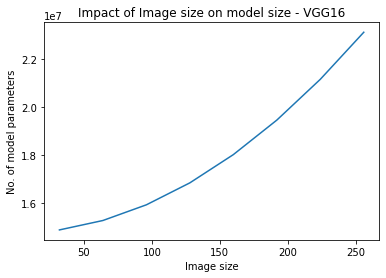

In [ ]:
plt.plot(img_size_list, n_params_list)
plt.xlabel("Image size")
plt.ylabel("No. of model parameters")
plt.title("Impact of Image size on model size - VGG16")
plt.show()

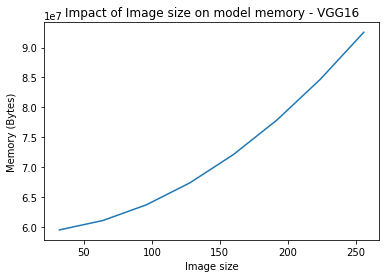

In [ ]:
memory_list = [p * number_size for p in n_params_list]
plt.plot(img_size_list, memory_list)
plt.xlabel("Image size")
plt.ylabel("Memory (Bytes)")
plt.title("Impact of Image size on model memory - VGG16")
plt.show()

# At max we reached 88.25 MB

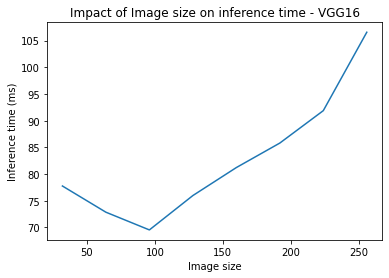

In [ ]:
plt.plot(img_size_list, infer_time_list)
plt.xlabel("Image size")
plt.ylabel("Inference time (ms)")
plt.title("Impact of Image size on inference time - VGG16")
plt.show()

## Investigating the impact layer

In [ ]:
i=1
img_shape = (32*i, 32*i, 3) 
model = VGG16(img_shape)
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_223 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_224 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_225 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_226 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 8, 8, 128)        0         
 ng2D)                                               

In [ ]:
i=4
img_shape = (32*i, 32*i, 3) # 64 x 64
model = VGG16(img_shape)
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_236 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 conv2d_237 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 64, 64, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_238 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_239 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 32, 32, 128)      0         
 ng2D)                                               

## Measure Performance and Training time

In [10]:
# define all classes and functions

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	# one hot encode target values
	trainY = keras.utils.to_categorical(trainY)
	testY = keras.utils.to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test, img_size):
    # resize the images
    train = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), train)))
    test = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), test)))
	# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
	# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
	# return normalized images
    return train_norm, test_norm
 
# define cnn model
def define_model(img_shape):
	model = VGG16(img_shape)
	# compile model
	opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.show()

 
# run the test harness for evaluating a model
def train_n_eval(img_shape):
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX, img_shape[0])
	# define model
	model = define_model(img_shape)
	# fit model
	history = model.fit(trainX, trainY, epochs=2, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)


In [ ]:
img_size_list = []
acc_list = []
train_time_list = []

for i in range(0,3): #6
    # define image shapes
    img_shape = (32+8*i, 32+8*i, 3)
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX, img_shape[0])
    img_size_list.append(trainX.shape[1]) ## save
	# define model
    model = define_model(img_shape)
    # call back to record training time
    cb = TimingCallback()
	# fit model
    history = model.fit(trainX, trainY, epochs=30, batch_size=8, validation_data=(testX, testY), callbacks=[cb]) # , verbose=0
	# evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    # print('> %.3f' % (acc * 100.0))
    print(f"Image shape:{img_shape[0]},\t Performance (accuracy): {acc * 100.0},\t Training time (sec):{sum(cb.logs)}")
    acc_list.append(acc) ## save
    train_time_list.append(sum(cb.logs))

Epoch 1/30
6250/6250 [==============================] - 138s 22ms/step - loss: 2.3023 - accuracy: 0.1077 - val_loss: 2.3019 - val_accuracy: 0.1070
Epoch 2/30
6250/6250 [==============================] - 140s 22ms/step - loss: 2.3014 - accuracy: 0.1201 - val_loss: 2.3005 - val_accuracy: 0.1111
Epoch 3/30
6250/6250 [==============================] - 140s 22ms/step - loss: 2.2976 - accuracy: 0.1403 - val_loss: 2.2910 - val_accuracy: 0.1746
Epoch 4/30
6250/6250 [==============================] - 138s 22ms/step - loss: 2.2307 - accuracy: 0.1702 - val_loss: 2.1344 - val_accuracy: 0.2277
Epoch 5/30
6250/6250 [==============================] - 140s 22ms/step - loss: 2.0211 - accuracy: 0.2514 - val_loss: 1.9366 - val_accuracy: 0.2824
Epoch 6/30
6250/6250 [==============================] - 140s 22ms/step - loss: 1.9151 - accuracy: 0.2907 - val_loss: 1.9188 - val_accuracy: 0.2854
Epoch 7/30
6250/6250 [==============================] - 141s 22ms/step - loss: 1.8005 - accuracy: 0.3371 - val_loss: 1

In [ ]:
plt.plot(img_size_list, acc_list)
plt.xlabel("Image size")
plt.ylabel("Accuracy (%)")
plt.title("Impact of Image size on model accuracy - VGG")
plt.show()

In [ ]:
plt.plot(img_size_list, train_time_list)
plt.xlabel("Image size")
plt.ylabel("Train time (sec)")
plt.title("Impact of Image size on training time - VGG")
plt.show()

In [ ]:
perf_change = [ ((acc_list[i] - acc_list[i-1])/acc_list[i-1])*100  for i in range(1, len(acc_list))]
time_change = [ ((train_time_list[i] - train_time_list[i-1])/train_time_list[i-1])*100  for i in range(1, len(train_time_list))]

perf_change.insert(0, 0) # no improvement at index 0
time_change.insert(0, 0)

In [ ]:
plt.plot(img_size_list, perf_change)
plt.xlabel("Image size")
plt.ylabel("Accuracy change (%)")
plt.title("Impact of Image size on model accuracy (change) - VGG")
plt.show()

In [ ]:
plt.plot(img_size_list, time_change)
plt.xlabel("Image size")
plt.ylabel("Train change (%)")
plt.title("Impact of Image size on training time (change) - VGG")
plt.show()